<a href="https://colab.research.google.com/github/matthewshawnkehoe/Data-Analysis/blob/main/testnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Beyond text classification: Sequence-to-sequence learning

You now possess all of the tools you will need to tackle most natural language process-ing  tasks.  However,  you've  only  seen  these  tools  in  action  on  a  single  problem:  textclassification.  This  is  an  extremely  popular  use  case,  but  there's  a  lot  more  to  NLPthan  classification.  In  this  section,  you'll  deepen  your  expertise  by  learning  about **sequence-to-sequence** models.

A  sequence-to-sequence  model  takes  a  sequence  as  input  (often  a  sentence  orparagraph) and translates it into a different sequence. This is the task at the heart ofmany of the most successful applications of NLP:

- Machine translation—Convert a paragraph in a source language to its equivalentin a target language.
- Text summarization—Convert a long document to a shorter version that retainsthe most important information.
- Question answering—Convert an input question into its answer.
- Chatbots—Convert a dialogue prompt into a reply to this prompt, or convert thehistory of a conversation into the next reply in the conversation.
- Text generation—Convert a text prompt into a paragraph that completes the prompt.

The general template behind sequence-to-sequence models is described in the figure below. During training,

- An **encoder** model turns the source sequence into an intermediate representation.
- A **decoder** is trained to predict the next token `i` in the target sequence by lookingat both previous tokens (`0` to `i-1`) and the encoded source sequence.

During  inference,  we  don't  have  access  to  the  target  sequence—we're  trying  to  pre-dict it from scratch. We'll have to generate it one token at a time:

1. We obtain the encoded source sequence from the encoder.
2. The decoder starts by looking at the encoded source sequence as well as an initial “seed” token (such as the string "`[start]`"), and uses them to predict the first real token in the sequence.
3. The predicted sequence so far is fed back into the decoder, which generates the next  token,  and  so  on,  until  it  generates  a  stop  token  (such  as  the  string "`[end]`").



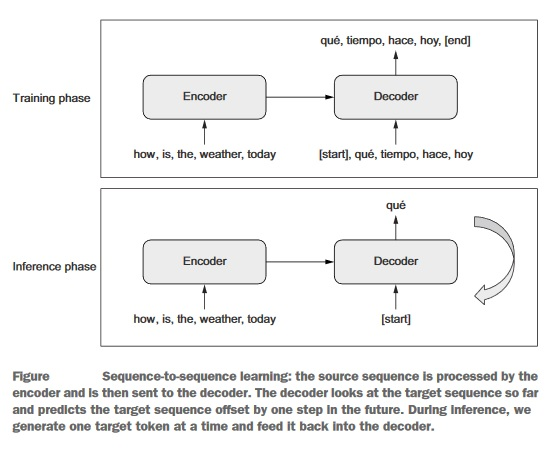

Everything you've learned so far can be repurposed to build this new kind of model. Let's dive in.

### A machine translation example

We'll  demonstrate  sequence-to-sequence  modeling  on  a  machine  translation  task. Machine translation is precisely what Transformer was developed for! We'll start with arecurrent sequence model, and we'll follow up with the full Transformer architecture.

We’ll  be  working  with  an  English-to-Spanish  translation  dataset  available  at www.manythings.org/anki/. Let's download it:

In [22]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
!unzip -q spa-eng.zip

--2023-09-20 23:09:05--  http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.207, 142.250.103.207, 142.251.172.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2638744 (2.5M) [application/zip]
Saving to: ‘spa-eng.zip.2’

spa-eng.zip.2       100%[===================>]   2.52M  --.-KB/s    in 0.01s   

2023-09-20 23:09:05 (200 MB/s) - ‘spa-eng.zip.2’ saved [2638744/2638744]

replace spa-eng/_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace spa-eng/spa.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


The  text  file  contains  one  example  per  line:  an  English  sentence,  followed  by  a  tab character, followed by the corresponding Spanish sentence. Let's parse this file.

In [23]:
text_file = "spa-eng/spa.txt"
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:                                                              # Iterate over the lines in the file.
    english, spanish = line.split("\t")                                         # Each line contains an English phrase and its Spanish
                                                                                # translation, tab-separated. We prepend "[start]"
    spanish = "[start] " + spanish + " [end]"                                   # and append "[end]" to the Spanish sentence to match
                                                                                # the template in the figure above.
    text_pairs.append((english, spanish))

Our `text_pairs` look like this:

In [ ]:
import random
print(random.choice(text_pairs))

('Our teacher is a real idiot.', '[start] Nuestro maestro es un perfecto idiota. [end]')


Let's shuffle them and split them into the usual training, validation, and test sets:

In [24]:
import random
random.shuffle(text_pairs)                                                      # Reorganizes the list
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]                                    # The first 70%
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]   # The next 15%
test_pairs = text_pairs[num_train_samples + num_val_samples:]                   # The remaining 15%

Next, let's prepare two separate `TextVectorization` layers: one for English and one for Spanish. We`re going to need to customize the way strings are preprocessed:

- We need to preserve the "`[start]`" and "`[end]`" tokens that we've inserted. By default,  the  characters  `[  and  ]`  would  be  stripped,  but  we  want  to  keep  them around so we can tell apart the word “start” and the start token "`[start]`".
- Punctuation  is  different  from  language  to  language!  In  the  Spanish  `TextVectorization` layer, if we're going to strip punctuation characters, we need to also strip the character ¿.

Note that for a non-toy translation model, we would treat punctuation characters as separate tokens rather than stripping them, since we would want to be able to generate correctly punctuated sentences. In our case, for simplicity, we'll get rid of all punctuation.

**Vectorizing the English and Spanish text pairs**

In [41]:
!pip install --upgrade tensorflow

In [42]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"                                          # Prepare a custom string standardization function for
strip_chars = strip_chars.replace("[", "")                                      # the Spanish TextVectorization layer: it preserves [ and ]
strip_chars = strip_chars.replace("]", "")                                      # but strips ¿ (as well as all other characters from
                                                                                # strings.punctuation).
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000                                                              # To keep things simple, we’ll only look at the top 15,000 words
sequence_length = 20                                                            # in each language, and we’ll restrict sentences to 20 words.

source_vectorization = layers.TextVectorization(                                # The English layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(                                # The Spanish layer
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,                                 # Generate Spanish sentences that have one extra token, since
                                                                                # we’ll need to offset the sentence by one step during training
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_spanish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)                                 # Learn the vocabulary of every language.

Finally,  we  can  turn  our  data  into  a  `tf.data` pipeline. We want it to return a tuple `(inputs,target)` where `inputs` is a `dict` with two keys, “encoder_inputs” (the English sentence)  and “decoder_inputs”  (the  Spanish  sentence),  and  target  is  the  Spanish sentence offset by one step ahead.

**Preparing datasets for the translation task**

In [43]:
batch_size = 64

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)
    return ({
        "english": eng,
        "spanish": spa[:, :-1],                                                 # The input Spanish sentence doesn’t include the last token
                                                                                # to keep inputs and targets at the same length.
    }, spa[:, 1:])                                                              # The target Spanish sentence is one step ahead.
                                                                                # Both are still the same length (20 words).

def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()                           # Use in-memory caching to speed up preprocessing.

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Here's what our dataset outputs look like:

In [44]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['spanish'].shape: {inputs['spanish'].shape}")
    print(f"targets.shape: {targets.shape}")

FailedPreconditionError: ignored

The  data  is  now  ready—time  to  build  some  models.  We'll  start  with  a  recurrent sequence-to-sequence model before moving on to a Transformer

### Sequence-to-sequence learning with RNNs

Recurrent  neural  networks  dominated  sequence-to-sequence  learning  from  2015–2017  before  being  overtaken  by  Transformer.  They  were  the  basis  for  many  real-world machine-translation systems—as mentioned in chapter 10, Google Translate circa 2017 was powered by a stack of seven large LSTM layers. It's still worth learning about  this  approach  today,  as it provides an easy entry  point to  understanding sequence-to-sequence models.

 The simplest, naive way to use RNNs to turn a sequence into another sequence isto keep the output of the RNN at each time step. In Keras, it would look like this:

In [ ]:
# Psuedocode

inputs = keras.Input(shape=(sequence_length,), dtype="int64")
x = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)

However, there are two major issues with this approach:

1. The target sequence must always be the same length as the source sequence. In practice, this is rarely the case. Technically, this isn't critical, as you could always  pad  either  the  source  sequence  or  the  target  sequence  to  make  their lengths match.

2. Due  to  the  step-by-step  nature  of  RNNs,  the  model  will  only  be  looking  at tokens 0...N in the source sequence in order to predict token N in the target sequence.  This  constraint  makes  this  setup  unsuitable  for  most  tasks,  and particularly  translation.  Consider  translating  “The  weather  is  nice  today”  to French—that  would  be  “Il  fait  beau  aujourd'hui.”  You'd  need  to  be  able to predict “Il” from just “The,” “Il fait” from just “The weather,” etc., which is simply impossible.

If you're a human translator, you'd start by reading the entire source sentence beforestarting  to  translate  it.  This  is  especially  important  if  you're  dealing  with  languages that have wildly different word ordering, like English and Japanese. And that's exactly what standard sequence-to-sequence models do.

In a proper sequence-to-sequence setup (see figure below), you would first use an RNN (the encoder) to turn the entire source sequence into a single vector (or set of vectors). This could be the last output of the RNN, or alternatively, its final internal state vectors. Then you would use this vector (or vectors) as the initial state of another RNN (the decoder), which would look at elements 0...N in the target sequence, and try to predict step N+1 in the target sequence.



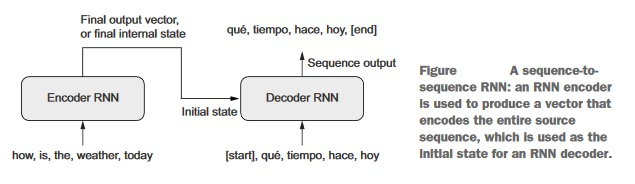

 Let's implement this in Keras with GRU-based encoders and decoders. The choiceof  GRU  rather  than  LSTM  makes  things  a  bit  simpler,  since  GRU  only  has  a  single state vector, whereas LSTM has multiple. Let's start with the encoder.

**GRU-based encoder**

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name="english")              # The English source sentence goes here. Specifying the name of
                                                                                # the input enables us to fit() the model with a dict of inputs.
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)             # Don’t forget masking: it’s critical in this setup.
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)                                # Our encoded source sentence is the last output of a
                                                                                # bidirectional GRU.

Next,  let's  add  the  decoder—a  simple  GRU  layer  that  takes  as  its  initial  state  theencoded source sentence. On top of it, we add a **Dense** layer that produces for each output step a probability distribution over the Spanish vocabulary.

**GRU-based decoder and the end-to-end model**

In [28]:
past_target = keras.Input(shape=(None,), dtype="int64", name="spanish")         # The Spanish target sentence goes here.
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)        # Don't forget masking.
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)                  # The encoded source sentence serves as the initial state of the decoder GRU.
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)            # Predicts the next token.
seq2seq_rnn = keras.Model([source, past_target], target_next_step)              # End-to-end model: maps the source sentence and the target
                                                                                # sentence to the target sentence one step in the future.

During training, the decoder takes as input the entire target sequence, but thanks to the step-by-step nature of RNNs, it only looks at tokens 0...N in the input to predict token N  in  the  output  (which  corresponds  to  the  next  token  in  the  sequence,  since the output is intended to be offset by one step). This means we only use information from the past to predict the future, as we should; otherwise we'd be cheating, and our model would not work at inference time.

 Let's start training.

**Training our recurrent sequence-to-sequence model**

In [34]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
seq2seq_rnn.fit(train_ds, epochs=15, validation_data=val_ds)

AttributeError: ignored

We  picked  accuracy  as  a  crude  way  to  monitor  validation-set  performance  during training. We get to 66% accuracy: on average, the model predicts the next word in the Spanish sentence correctly 66% of the time. However, in practice, next-token accuracy isn't a great metric for machine translation models, in particular because it makes the assumption  that  the  correct  target  tokens  from  0  to  N  are  already  known  when  predicting token N+1. In reality, during inference, you're generating the target sentence from scratch, and you can't rely on previously generated tokens being 100% correct. If you  work  on  a  real-world  machine  translation  system,  you  will  likely  use  “BLEUscores”  to  evaluate  your  models—a  metric  that  looks  at  entire  generated  sequences and that seems to correlate well with human perception of translation quality.

At last, let's use our model for inference. We'll pick a few sentences in the test set and check how our model translates them. We'll start from the seed token, "`[start]`",and  feed  it  into  the  decoder  model,  together  with  the  encoded  English  source  sentence.  We'll  retrieve  a  next-token  prediction,  and  we'll  re-inject  it  into  the  decoder repeatedly, sampling one new target token at each iteration, until we get to "`[end]`" or reach the maximum sentence length

**Translating new sentences with our RNN encoder and decoder**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()                               # Prepare a dict to convert token index predictions to
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))                  # string tokens.
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"                                                # Seed token.
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(                           # Sample the next token.
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]                   # Convert the next token prediction to a string and
        decoded_sentence += " " + sampled_token                                 # append it to the generated sentence.
        if sampled_token == "[end]":                                            # Exit condition: either hit max length or sample
            break                                                               # a stop character.
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
We will get married in June.
1/1 [==============================] - 0s 25ms/step
[start] nos [UNK] en octubre [end]
-
This is Tom's bedroom.
1/1 [==============================] - 0s 25ms/step
[start] esta es la habitación de tom [end]
-
It's a miracle that you were able to survive.
1/1 [==============================] - 0s 25ms/step
[start] es un riesgo que no podemos venir [end]
-
Do you play basketball well?
1/1 [==============================] - 0s 23ms/step
[start] vas a jugar bien el violín [end]
-
Nice to see you, Tom.
1/1 [==============================] - 0s 25ms/step
[start] qué bueno verte tom [end]
-
That was my big mistake.
1/1 [==============================] - 0s 39ms/step
[start] eso fue mi gran error [end]
-
The lessons are getting more and more difficult.
1/1 [==============================] - 0s 34ms/step
[start] las chicas se están más y más y más [end]
-
I ran toward the door.
1/1 [==============================] - 0s 96ms/step
[start] me quedé corriendo la puert

Note that this inference setup, while very simple, is rather inefficient, since we reprocess  the  entire  source  sentence  and  the  entire  generated  target  sentence  every  time we  sample  a  new  word.  In  a  practical  application,  you'd  factor  the  encoder  and  the decoder  as  two  separate  models,  and  your  decoder  would  only  run  a  single  step  at each token-sampling iteration, reusing its previous internal state.

Here are some more translation results. Our model works decently well for a toy model, though it still makes many basic mistakes.

In [ ]:
Who is in this room?
[start] quién está en esta habitación [end]
-
That doesn't sound too dangerous.
[start] eso no es muy difícil [end]
-
No one will stop me.
 [start] nadie me va a hacer [end]
 -Tom is friendly.
  [start] tom es un buen [UNK] [end]

SyntaxError: ignored

There  are  many  ways  this  toy  model  could  be  improved:  We  could  use  a  deep  stack  of recurrent layers for both the encoder and the decoder (note that for the decoder, this makes state management a bit more involved). We could use an LSTM instead of a GRU. And so on.  Beyond  such  tweaks,  however,  the  RNN  approach  to  sequence-to-sequence learning has a few fundamental limitations:

*   The source sequence representation has to be held entirely in the encoder state vector(s),  which  puts  significant  limitations  on  the  size  and  complexity  of  thesentences you can translate. It's a bit as if a human were translating a sentenc eentirely from memory, without looking twice at the source sentence while producing the translation.
*   RNNs  have  trouble  dealing  with  very  long  sequences,  since  they  tend  to  progressively forget about the past—by the time you've reached the 100th token ineither  sequence,  little  information  remains  about  the  start  of  the  sequence. That  means  RNN-based  models  can't  hold  onto  long-term  context,  which  can be essential for translating long documents.

These limitations are what has led the machine learning community to embrace theTransformer architecture for sequence-to-sequence problems. Let's take a look.


### Sequence-to-sequence learning with Transformer

Sequence-to-sequence  learning  is  the  task  where  Transformer  really  shines.  Neural attention enables Transformer models to successfully process sequences that are considerably longer and more complex than those RNNs can handle.

As a human translating English to Spanish, you're not going to read the English sentence one word at a time, keep its meaning in memory, and then generate the Spanish sentence one word at a time. That may work for a five-word sentence, but it's  unlikely  to  work  for  an  entire  paragraph.  Instead,  you'll  probably  want  to  go back  and  forth  between  the  source  sentence and your translation in progress, and pay attention to different words in the source as you're writing down different parts of your translation.

That's  exactly  what  you  can  achieve  with  neural  attention  and  Transformers. You're already familiar with the Transformer encoder, which uses self-attention to produce  context-aware  representations  of  each  token  in  an  input  sequence.  In  a sequence-to-sequence Transformer, the **Transformer encoder** would naturally play the role of the encoder, which reads the source sequence and produces an encoded representation  of  it.  Unlike  our  previous  RNN  encoder,  though,  the  Transformerencoder  keeps  the  encoded  representation  in  a  sequence  format:  it's  a  sequence  of context-aware embedding vectors.

The second half of the model is the **Transformer decoder**. Just like the RNN decoder, it  reads  tokens  `0...N`  in  the  target  sequence  and  tries  to  predict  token  `N+1`.  Crucially, while doing this, it uses **neural attention** to identify which tokens in the encoded source sentence are most closely related to the target token it's currently trying to predict—perhaps  not  unlike  what  a  human  translator  would  do.  Recall  the  query-key-value model: in a Transformer decoder, the target sequence serves as an attention “query” that  is  used  to  to  pay  closer  attention  to  different  parts  of  the  source  sequence  (the source sequence plays the roles of both keys and values).

#### The Transformer decoder

The Figure below shows the full sequence-to-sequence Transformer. Look at the decoder internals: you'll recognize that it looks very similar to the Transformer encoder, except that  an  extra  attention  block  is  inserted  between  the  self-attention  block  applied to the target sequence and the dense layers of the exit block.

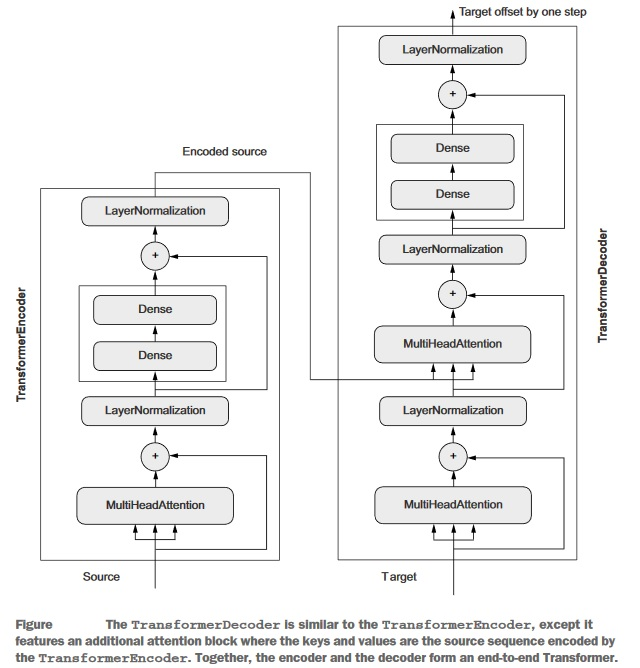

  TODO - Fix code order below

**The `TransformerDecoder`**

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True                                            # This attribute ensures that the layer will propagate
                                                                                # its input mask to its outputs; masking in Keras is explicitly
                                                                                # opt-in. If you pass a mask to a layer that doesn’t implement
                                                                                # compute_mask() and that doesn’t expose this supports_masking
                                                                                # attribute, that’s an error.
   # TODO - Add Get_config()!

The `call()` method is almost a straightforward rendering of the connectivity diagram from Transformers architecture. But there's an additional detail we need to take into account: causal padding. Causal padding is absolutely critical to successfully training a sequence-to-sequence Transformer. Unlike an RNN, which looks at its input one step at a time, and thus will only have access to steps `0...N` to generate output step `N`(which is token `N+1` in the target sequence), the TransformerDecoder is order-agnostic: it looks at the entire target sequence at once. If it were allowed to use its entire input, it would simply learn to copy input step `N+1` to location `N` in the output. The model would thus achieve perfect training accuracy, but of course, when running inference, it would be completely useless, since input steps beyond `N` aren't available.

The fix is simple: we'll mask the upper half of the pairwise attention matrix to prevent the model from paying any attention to information from the future—only information  from  tokens `0...N` in the target sequence should be used when generating target token `N+1`. To do this, we'll add a `get_causal_attention_mask(self,inputs)` method to our TransformerDecoder to retrieve an attention mask that we can pass to our MultiHeadAttention layers.



In [ ]:
def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))  # Generate matrix of shape (sequence_length, sequence_length) with 1s
                                                                      # in one half and 0s in the other.
        mult = tf.concat(                                             # Replicate it along thebatch axis to get a matrix of .
            [tf.expand_dims(batch_size, -1),                          # shape (batch_size,sequence_length,sequence_length)
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)


Now we can write down the full `call()` method implementing the forward pass of the decoder.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Putting it all together: A Transformer for machine translation

**PositionalEmbedding layer**

The  end-to-end  Transformer  is  the  model  we'll  be  training.  It  maps  the  source sequence  and  the  target  sequence  to  the  target  sequence  one  step  in  the  future.  It straightforwardly combines the pieces we've built so far: `PositionalEmbedding` layers, the  `TransformerEncoder`,  and  the  `TransformerDecoder`.  Note  that  both  the  TransformerEncoder  and  the  TransformerDecoder  are shape-invariant,  so  you  could  be stacking many of them to create a more powerful encoder or decoder. In our example, we'll stick to a single instance of each.

**End-to-end Transformer**

In [ ]:
!pip install flair==0.4.3

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)        # Encode the source sequence.

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)     # Encode the target sentence and combine it with the encoded source sentence.
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)             # Predict a word for each output position.
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.0/180.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.8/118.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.3/774.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

NameError: ignored

We’re now ready to train our model—we get to 67% accuracy, a good deal above the
GRU-based model.

**Training the sequence-to-sequence Transformer**

In [ ]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
transformer.fit(train_ds, epochs=30, validation_data=val_ds)

Finally, let's try using our model to translate never-seen-before English sentences from the test set. The setup is identical to what we used for the sequence-to-sequence RNN model.

**Translating new sentences with our Transformer model**

In [ ]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(                                              # Sample the next token
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]                   # Convert the next token prediction to a string,
        decoded_sentence += " " + sampled_token                                 # an append it to the generated sentence.
        if sampled_token == "[end]":                                            # exit condition
            break
    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

Subjectively,  the  Transformer  seems  to  perform  significantly  better  than  the  GRU-based translation model. It's still a toy model, but it's a better toy model.

That concludes this chapter on natural language processing—you just went from the very basics to a fully fledged Transformer that can translate from English to Spanish. Teaching machines to make sense of language is the latest superpower you can add to your collection.

## Summary

- There are two kinds of NLP models: **bag-of-words** models that process sets of words or N-grams without taking into account their order, and **sequence models** that process word order. A bag-of-words model is made of `Dense` layers, while a sequence model could be an RNN, a 1D convnet, or a Transformer.
- When it comes to text classification, the ratio between the number of samples
in your training data and the mean number of words per sample can help you
determine whether you should use a bag-of-words model or a sequence model.
- Word embeddings are vector spaces where semantic relationships between words are modeled as distance relationships between vectors that represent those words.
- Sequence-to-sequence learning is a generic, powerful learning framework that can be
applied to solve many NLP problems, including machine translation. A sequence-
to-sequence  model  is  made  of  an  encoder,  which  processes  a  source  sequence, and a decoder, which tries to predict future tokens in target sequence by looking at past tokens, with the help of the encoder-processed source sequence.
- Neural  attention  is  a  way  to  create  context-aware  word  representations.  It's  the basis for the Transformer architecture.
- The  Transformer  architecture,  which  consists  of  a  `TransformerEncoder`  and  a `TransformerDecoder`,  yields  excellent  results  on  sequence-to-sequence  tasks. The first half, the TransformerEncoder, can also be used for text classification or any sort of single-input NLP task.